In [1]:
from utils import *
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("defects.csv") as f:
    lines = f.readlines()
    defects = [line.strip().split(",") for line in lines[1:]]

# Defects never occur at precise integer coordinates, so a defect will never be shared by two tiles.
# We floor each defect coordinate to get the tile it belongs to.
# We then count the number of defects in each tile.
defect_counts = {}
for x, y in defects:
    x = int(float(x))
    if x not in defect_counts:
        defect_counts[x] = {"a": 0, "b": 0, "c": 0}

    defect_counts[x][y] += 1

print(len(defect_counts))

322


In [3]:
dough_length = 500

biscuits = {
    0: {"length": 4, "value": 6, "defects": {"a": 4, "b": 2, "c": 3}, "id": 0},
    1: {"length": 8, "value": 12, "defects": {"a": 5, "b": 4, "c": 4}, "id": 1},
    2: {"length": 2, "value": 1, "defects": {"a": 1, "b": 2, "c": 1}, "id": 2},
    3: {"length": 5, "value": 8, "defects": {"a": 2, "b": 3, "c": 2}, "id": 3},
}

In [12]:
class Individual:
    """
    Represents an individual in the genetic algorithm for biscuit production optimization.
    The chromosome is a list of <dough_length> biscuit types for each position. -1 represents a missing biscuit.
    Biscuit types are represented by integers 0, 1, 2, 3.
    e.g. [-1, -1, 2, -1, -1] represents a solution with a biscuit of type 2 at position 2.
    """

    def __init__(self, chromosome=None):
        """
        Initializes a new individual.

        Args:
            chromosome (list): The chromosome representing the biscuit types for each gene. If not provided, a random chromosome will be generated.

        Returns:
            None
        """
        if chromosome is None:
            self.initialize_chromosome()
        else:
            self.chromosome = chromosome
        self.fitness = self.calculate_fitness()

    @staticmethod
    def convert_chromosome_to_solution(chromosome):
        """
        Convert a chromosome to a solution (they have different formats).

        Args:
            chromosome (list): The chromosome to convert.

        Returns:
            list: The converted solution.
        """
        solution = []
        for position, biscuit_type in enumerate(chromosome):
            if biscuit_type in [0, 1, 2, 3]:
                solution.append((position, biscuit_type))
        return solution

    @staticmethod
    def convert_solution_to_chromosome(solution):
        """
        Convert a solution to a chromosome (they have different formats).

        Args:
            solution (list): The solution to convert.

        Returns:
            list: The converted chromosome.
        """
        chromosome = [-1] * dough_length
        for position, biscuit_type in solution:
            chromosome[position] = biscuit_type
        return chromosome

    def initialize_chromosome(self):
        """
        Initializes the chromosome by randomly selecting biscuit types for each gene.

        Returns:
            list: The initialized chromosome.
        """
        self.chromosome = [random.choice(list(biscuits.keys()) + [-1]) for _ in range(dough_length)]
        self.clean_chromosome()
        return self.chromosome

    def clean_chromosome(self):
        """
        Cleans the chromosome by removing invalid biscuits and updating the fitness.

        Returns:
            list: The cleaned chromosome.
        """
        self.chromosome = Individual.convert_solution_to_chromosome(check_solution(Individual.convert_chromosome_to_solution(self.chromosome))[1])
        self.fitness = self.calculate_fitness()
        return self.chromosome
    
    def calculate_fitness(self):
        """
        Calculates the fitness of the individual based on the biscuit in the chromosome.

        Returns:
            int: The fitness value.
        """
        return sum([biscuits[biscuit_type]['value'] for biscuit_type in self.chromosome if biscuit_type != -1])

    def mutate(self, mutation_rate):
        """
        Mutates the individual's chromosome by randomly changing some genes.

        Args:
            mutation_rate (float): The probability of a gene being mutated.

        Returns:
            list: The mutated chromosome.
        """
        chromosome_array = np.array(self.chromosome)
        mutation_indices = np.random.rand(len(chromosome_array)) < mutation_rate
        mutation_values = list(biscuits.keys()) + [-1]
        chromosome_array[mutation_indices] = np.random.choice(mutation_values, size=np.sum(mutation_indices))
        self.chromosome = chromosome_array.tolist()

        return self.chromosome

class GeneticAlgorithm:
    """
    A class representing a genetic algorithm.
    """

    def __init__(self, pop_size, mutation_rate, selection_rate):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = None
        self.selection_rate = selection_rate

        self.fitness_history = []

    def run(self, generations):
        """
        Runs the genetic algorithm for the specified number of generations.

        Args:
        - generations (int): The number of generations to run.

        Returns:
        - best_solution (Individual): The best solution found.
        """
        pop_size = self.pop_size
        mutation_rate = self.mutation_rate

        if self.population is None:
            self.population = self.initialize_population(pop_size)
        
        self.fitness_history.append([individual.fitness for individual in self.population])

        for i in range(generations):
            new_population = []
            population = self.tournament_selection(self.population, int(self.pop_size * self.selection_rate))
            while len(new_population) < pop_size:
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = self.crossover(parent1, parent2)
                child1.mutate(mutation_rate)
                child2.mutate(mutation_rate)
                child1.clean_chromosome()
                child2.clean_chromosome()
                new_population.extend([child1, child2])
            
            self.population = new_population
            best_fitness = max(ind.fitness for ind in self.population)
            print(f"Generation {i}, best fitness = {best_fitness}")
            self.fitness_history.append([individual.fitness for individual in self.population])

        best_solution = max(self.population, key=lambda x: x.fitness)
        return best_solution


    # Initialize population
    def initialize_population(self, pop_size):
        """
        Initializes the population with random individuals.

        Args:
        - pop_size (int): The size of the population.

        Returns:
        - population (list): The initialized population.
        """
        return [Individual() for _ in range(pop_size)]

    # Selection
    def tournament_selection(self, population, tournament_size):
        """
        Perform tournament selection on a population.

        Args:
        population (list): A list of individuals in the population.
        tournament_size (int): The number of individuals in each tournament.

        Returns:
        list: A list of selected individuals for crossover.
        """

        # Always select the best individual
        best_individual = max(population, key=lambda individual: individual.fitness)
        selected_individuals = [best_individual]

        for _ in range(len(population) // 2):
            # Select random individuals for the tournament
            tournament = random.sample(population, tournament_size)
            
            # Select the best individual from the tournament
            best_individual = max(tournament, key=lambda individual: individual.fitness)
            selected_individuals.append(best_individual)

        return selected_individuals

    # Crossover
    def crossover(self, parent1, parent2):
        """
        Performs crossover between two parents.

        Args:
        - parent1 (Individual): The first parent.
        - parent2 (Individual): The second parent.

        Returns:
        - child1 (Individual): The first child.
        - child2 (Individual): The second child.
        """
        crossover_point = random.randint(1, dough_length - 1)
        child1 = Individual(parent1.chromosome[:crossover_point] + parent2.chromosome[crossover_point:])
        child2 = Individual(parent2.chromosome[:crossover_point] + parent1.chromosome[crossover_point:])
        return child1, child2



In [13]:
# Genetic Algorithm Parameters
POP_SIZE = 1000
MUTATION_RATE = 0.05
GENERATIONS = 250
SELECTION_RATE = 0.05

genetic_algorithm = GeneticAlgorithm(POP_SIZE, MUTATION_RATE, SELECTION_RATE)
result = genetic_algorithm.run(GENERATIONS)

print(check_solution(Individual.convert_chromosome_to_solution(result.chromosome)))

Generation 0, best fitness = 642
Generation 1, best fitness = 658
Generation 2, best fitness = 654
Generation 3, best fitness = 665
Generation 4, best fitness = 671
Generation 5, best fitness = 672
Generation 6, best fitness = 678
Generation 7, best fitness = 685
Generation 8, best fitness = 686
Generation 9, best fitness = 691
Generation 10, best fitness = 692
Generation 11, best fitness = 693
Generation 12, best fitness = 695
Generation 13, best fitness = 698
Generation 14, best fitness = 701
Generation 15, best fitness = 703
Generation 16, best fitness = 705
Generation 17, best fitness = 706
Generation 18, best fitness = 708
Generation 19, best fitness = 706
Generation 20, best fitness = 709
Generation 21, best fitness = 708
Generation 22, best fitness = 710
Generation 23, best fitness = 710
Generation 24, best fitness = 710
Generation 25, best fitness = 710
Generation 26, best fitness = 710
Generation 27, best fitness = 710
Generation 28, best fitness = 711
Generation 29, best fitn

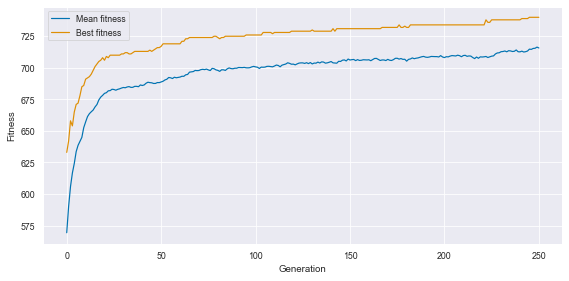

In [19]:
# Plot fitness history (mean and best fitness of each generation)

sns.set_style("darkgrid")
sns.set_palette("colorblind")
sns.set_context("paper")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.mean(genetic_algorithm.fitness_history, axis=1), label="Mean fitness")
ax.plot(np.max(genetic_algorithm.fitness_history, axis=1), label="Best fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
ax.legend()
plt.tight_layout()
plt.savefig("fitness_history_ga.png", dpi=300)
plt.show()


In [17]:
from utils import check_solution
# Build and check solution
solution = Individual.convert_chromosome_to_solution(result.chromosome)
print(check_solution(solution))

(740, [(0, 1), (8, 1), (16, 3), (21, 1), (29, 3), (34, 2), (36, 0), (40, 0), (45, 3), (50, 0), (54, 1), (62, 3), (67, 1), (75, 1), (83, 0), (87, 3), (92, 0), (98, 0), (102, 3), (107, 0), (111, 2), (114, 0), (118, 0), (122, 0), (126, 3), (131, 1), (139, 0), (144, 3), (149, 1), (158, 1), (167, 3), (172, 0), (176, 1), (185, 2), (188, 1), (196, 1), (204, 1), (212, 1), (220, 1), (228, 1), (236, 1), (244, 1), (252, 1), (260, 3), (265, 3), (270, 3), (275, 0), (279, 1), (287, 3), (294, 3), (299, 0), (303, 0), (307, 3), (312, 1), (320, 3), (325, 1), (333, 3), (338, 3), (343, 3), (348, 3), (353, 0), (357, 1), (365, 0), (369, 0), (373, 1), (381, 2), (383, 3), (388, 3), (393, 3), (398, 0), (402, 3), (407, 1), (415, 3), (420, 1), (428, 1), (436, 1), (444, 0), (448, 3), (453, 1), (461, 3), (466, 3), (471, 1), (479, 1), (487, 1), (495, 3)], True)


In [18]:
from utils import save_solution
# Save solution
save_solution(solution, "solution_genetic_algorithm.txt")